## Importações

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pycep_correios

from scipy import stats
from IPython.core.display  import HTML
from pandas.plotting import scatter_matrix
from statsmodels.formula.api import ols

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from pycep_correios import WebService, exceptions

## Funções Auxiliares

In [73]:
#Configurações do Jupyter Notebook
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [74]:
#Ativação das configurações do Jupyter Notebook
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Carregamento dos Dados

In [4]:
df = pd.read_csv('../data/apartamentoszn.csv', sep=';')

# Pré - Análise Exploratória dos Dados

### Conhecendo os Dados

#### Dimensão dos Dados

In [5]:
# Verificando a forma do dataframe
print( 'Número de Linhas : {}'.format( df.shape[0] ) )
print( 'Número de Colunas: {}'.format( df.shape[1] ) )

Número de Linhas : 4051
Número de Colunas: 15


#### Amostra dos Dados

In [6]:
# Verificando as 10 primeiras linhas do dataframe
df.head(10)

,codigo,titulo,valorreal,datapublicacao,horapublicacao,areautil,quartos,banheiros,vagas,condominio,iptu,cep,bairro,logradouro,pg
0,864419002,(MD-S)3 Quartos 2 Suítes e 2 Vagas - Andar Alt...,570201,01/04/2021,11:38,80,3.0,2,2,1.0,200.0,52041130,Encruzilhada,Rua Ceará,https://pe.olx.com.br/grande-recife/imoveis/md...
1,864383181,"VM-N- Lindo Apto com 3 quartos no Espinheiro, ...",425504,01/04/2021,10:24,64,3.0,2,1,1.0,200.0,52020020,Espinheiro,Rua Hipólito Braga,https://pe.olx.com.br/grande-recife/imoveis/vm...
2,864495499,"Vendo Um Lindo Apartamento, Bairro Arruda, Rec...",245000,01/04/2021,14:05,60,2.0,1,1,NaN,NaN,52120100,Arruda,Avenida Professor José dos Anjos - de 2001 a 2...,https://pe.olx.com.br/grande-recife/imoveis/ve...
3,864419252,JD Seu ap novo e pronto para morar em Água Fri...,304501,01/04/2021,11:40,67,3.0,2,1,1.0,1.0,52120321,Arruda,Rua Carlos Alberto Barbosa,https://pe.olx.com.br/grande-recife/imoveis/jd...
4,839257726,"RB Apartamento, 3 quartos , varanda , pronto p...",285015,01/04/2021,09:08,76,3.0,2,1,900.0,1880.0,52041535,Encruzilhada,Rua Mem de Sá - de 180/181 ao fim,https://pe.olx.com.br/grande-recife/imoveis/rb...
5,787915790,FG* Apto Pronto 3Qts-2 Vagas de garagem-83m² E...,535000,01/04/2021,11:26,83,3.0,3,2,600.0,1.0,52041310,Rosarinho,Rua Hipólito Braga,https://pe.olx.com.br/grande-recife/imoveis/fg...
6,815505466,EM-Excelente Apartamento no Rosarinho com 3 qu...,430299,01/04/2021,11:07,85,3.0,3,2,1.0,200.0,52050500,Rosarinho,Avenida Santos Dumont - de 493 ao fim - lado í...,https://pe.olx.com.br/grande-recife/imoveis/em...
7,816725963,"VM-Lançamento do melhor 3 quartos das Graças, ...",562112,01/04/2021,10:56,85,3.0,3,2,600.0,1.0,52050050,Graças,Avenida Santos Dumont - até 455 - lado ímpar,https://pe.olx.com.br/grande-recife/imoveis/vm...
8,838942891,Apartamento no Rosarinho 2 quartos,320000,01/04/2021,01:18,69,2.0,2,1,630.0,1700.0,52050500,Rosarinho,Avenida Santos Dumont - de 493 ao fim - lado í...,https://pe.olx.com.br/grande-recife/imoveis/ap...
9,864154340,Vendo Apartmento no Espinheiro,430000,31/03/2021,17:28,75,3.0,2,1,662.0,1880.0,52020025,Espinheiro,Rua do Espinheiro - de 478/479 ao fim,https://pe.olx.com.br/grande-recife/imoveis/ve...


#### Tipos dos Dados

In [29]:
# Verificando os tipos dos dados do dataframe
df.dtypes

codigo                    object
titulo                    object
valorreal                  int64
datapublicacao    datetime64[ns]
horapublicacao            object
areautil                   int64
quartos                  float64
banheiros                  int64
vagas                      int64
condominio               float64
iptu                     float64
cep                       object
bairro                    object
logradouro                object
pg                        object
dtype: object

### Transformação e Limpeza dos Dados

#### Transformação dos Dados

In [8]:
# Convertendo atributos inteiras em texto
df['codigo'] = df['codigo'].apply(str)
df['cep'] = df['cep'].apply(str)

# Convertendo atributos data
df['datapublicacao'] = pd.to_datetime( df['datapublicacao'] )

# Convertendo a coluna Bairro para maíscula, evitando agrupamentos diferentes para mesmo bairro.
df['bairro'] = df['bairro'].str.upper()

#### Dados Ausente

In [9]:
# Verificando quantidade de dados ausentes no dataframe
df.isna().sum()

codigo              0
titulo              0
valorreal           0
datapublicacao      0
horapublicacao      0
areautil            0
quartos             1
banheiros           0
vagas               0
condominio        171
iptu              302
cep                 0
bairro              0
logradouro         16
pg                  0
dtype: int64

In [10]:
# Verificando porcentagem de dados ausentes no dataframe
df.isna().mean().round(4).sort_values(ascending=False) * 100

iptu              7.45
condominio        4.22
logradouro        0.39
quartos           0.02
pg                0.00
bairro            0.00
cep               0.00
vagas             0.00
banheiros         0.00
areautil          0.00
horapublicacao    0.00
datapublicacao    0.00
valorreal         0.00
titulo            0.00
codigo            0.00
dtype: float64

A maior ausência de informações foram nos atributos **iptu** e **condominio**, onde na plataforma de origem dos dados não são informações obrigatórias. 
Para não atribuir algum valor para esses atributos, os registros com esses dados ausentes serão removidos visto que a porcentagem total não é tão significante.

In [11]:
# Removendo registros com dados ausentes
df.dropna(inplace=True)

### Identificação e Tratamento de Outliers

#### Identificação de possíveis Outliers

In [30]:
# Estátistica Descritiva dos atributos númericos
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,valorreal,areautil,quartos,banheiros,vagas,condominio,iptu
count,3612.00,3612.00,3612.00,3612.00,3612.00,3612.00,3612.00
mean,424242.46,79.83,2.96,2.35,1.34,511.54,424.47
std,106489.59,21.48,0.32,0.60,0.51,365.31,761.51
min,100000.00,60.00,1.00,0.00,0.00,0.00,0.00
25%,330000.00,67.00,3.00,2.00,1.00,1.00,1.00
50%,430522.00,76.00,3.00,2.00,1.00,590.00,110.00
75%,509999.25,85.00,3.00,3.00,2.00,750.00,250.00
max,600000.00,326.00,5.00,5.00,5.00,2000.00,4700.00


Através da estatística descritiva dos atributos numéricos podemos identificar alguns valores que estão fora da curva, como identificado no valor mínimo do atributo **valorreal** e nos valores máximos dos atributos **areautil**, **condomínio** e **iptu**.

<AxesSubplot:xlabel='iptu'>

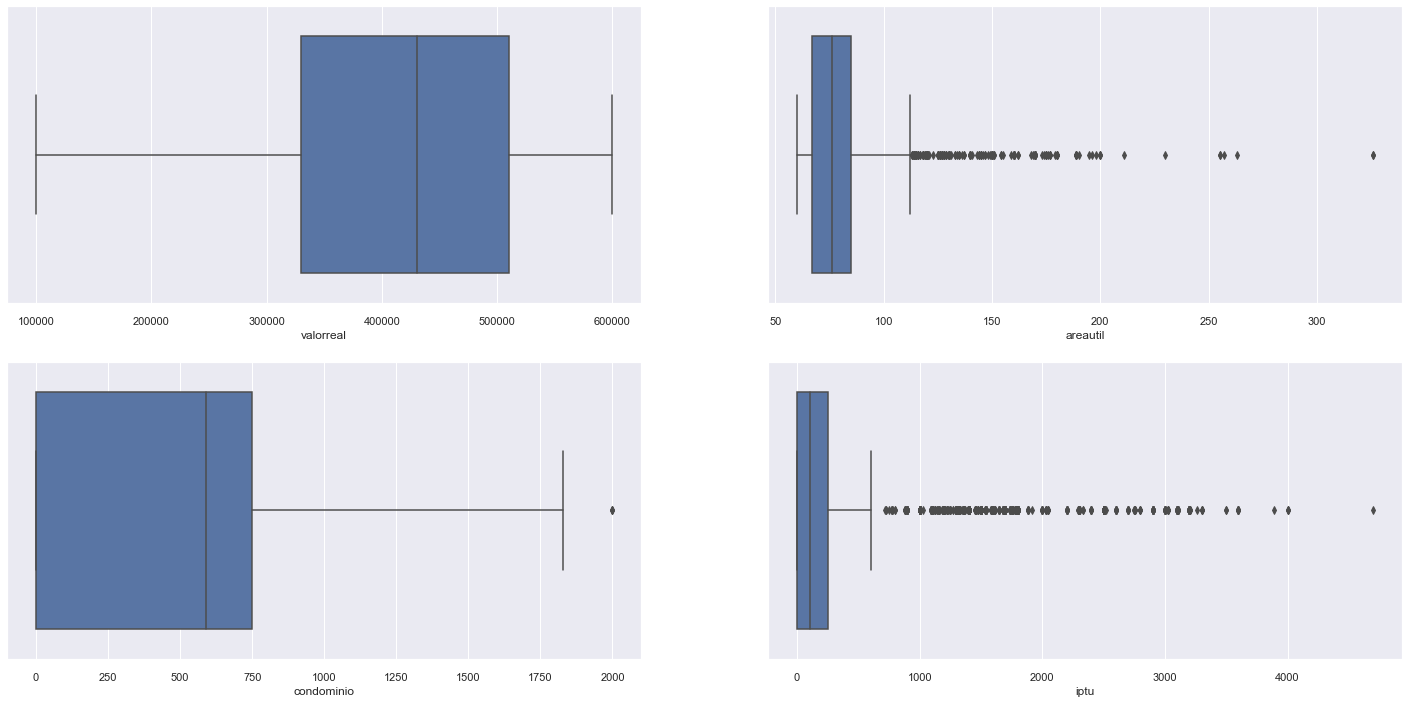

In [33]:
#Plotagem dos boxplots dos atributos que possuem valores fora da curva conforme identificado na estatística descritiva.

#amount
plt.subplot(2,2,1)
sns.boxplot(x=df['valorreal'])

#oldbalance_org
plt.subplot(2,2,2)
sns.boxplot(x=df['areautil'])

#newbalance_org
plt.subplot(2,2,3)
sns.boxplot(x=df['condominio'])

#newbalance_org
plt.subplot(2,2,4)
sns.boxplot(x=df['iptu'])

#### Tratamento dos Outliers

Conforme boxplot dos atributos, identificamos os seguintes cenários:
* No atributo **valorreal** identificamos valores que estão abaixo do limite mínimo estabelecido a esquerda do gráfico.
* No atributo **areautil** identificamos valores que estão acima de metragens convencionais para tamanhos de apartamentos, conforme exibido no limite máximo estabelecido a direita do gráfico.
* No atributo **condominio** identificamos valores que estão acima de valores convencionais para apartamentos, conforme exibido no limite máximo estabelecido a direita do gráfico.
* No atributo **iptu** identificamos valores que estão acima de valores convencionais para apartamentos, conforme exibido no limite máximo estabelecido a direita do gráfico.

In [14]:
# Removendo registros com valores fora do padrão
df_outlier = df.loc[(df['valorreal'] < 100000) | (df['areautil'] > 500) | (df['condominio'] > 5000) | (df['iptu'] > 5000)]
df = df.drop(df_outlier.index)

### Feature Engineering

Para analisar a localização dos imóveis, criaremos as características de Latitude de Longitude dos imóveis.

# Análise Exploratória dos Dados

## Análise Univariada

### Variável de Resposta

<AxesSubplot:xlabel='valorreal', ylabel='Count'>

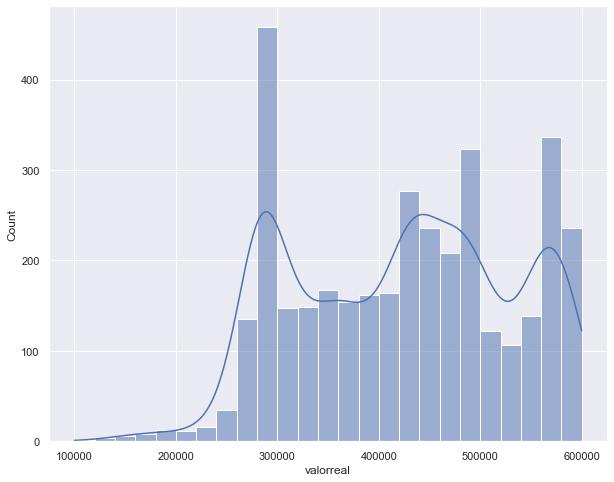

In [15]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='valorreal', kde=True, bins = 25)

### Variáveis Numéricas

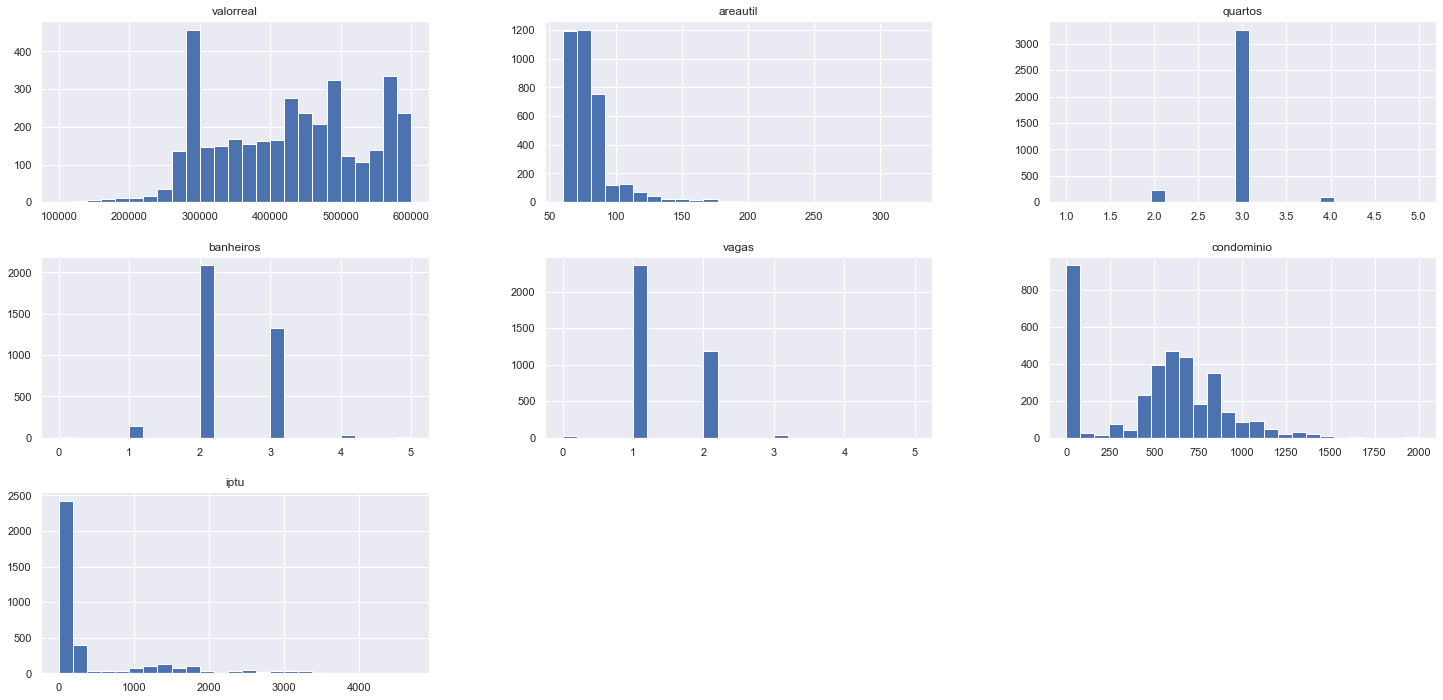

In [16]:
# Plotagem de histograma com distruibição dos atributos numéricos.
num_attributes = df.select_dtypes(exclude = ["object", "datetime"])
num_attributes.hist(bins = 25);

### Variáveis Categorica

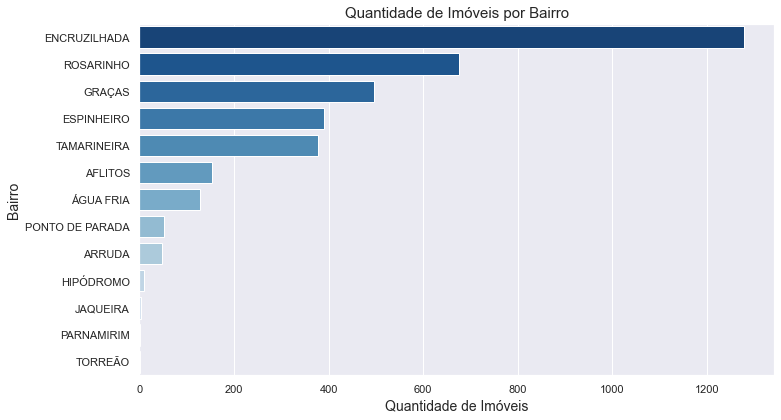

In [17]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.countplot(y = 'bairro', data = df, order=df['bairro'].value_counts().index, palette='Blues_r')
plt.xlabel("Quantidade de Imóveis", size=14)
plt.ylabel("Bairro", size=14)
plt.title("Quantidade de Imóveis por Bairro", size=15)
plt.tight_layout()
plt.savefig("imoveis_por_bairro.png", dpi=100)

## Análise Bivariada

* **H1** Imóveis com mais garagem devem ser mais caros.
* **H2** Imóveis com mais banheiros devem ser mais caros.
* **H3** Imóveis com mais quartos devem ser mais caros.
* **H4** Imóveis com maior área devem ser mais caros.
* **H5** Imóveis localizados em regiões mais populosas devem ser mais caros.
* **H6** Imóveis localizados mais próximos ao centro devem ser mais caros.

### **H1** Imóveis com mais garagem devem ser mais caros.

<AxesSubplot:>

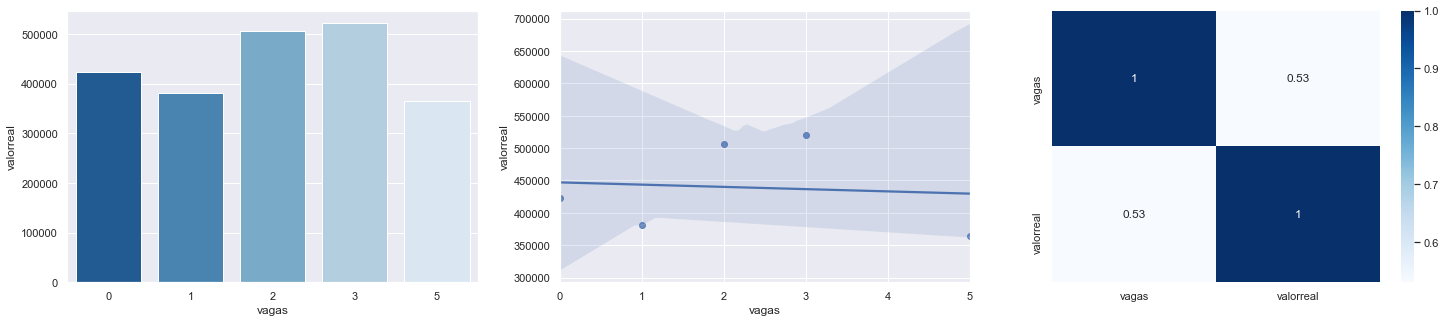

In [18]:
aux = df[['vagas','valorreal']].groupby('vagas').mean().reset_index()

plt.figure(figsize=(25,5))

#barplot
plt.subplot(1,3,1)
sns.barplot(x = 'vagas',y = 'valorreal', data = aux, palette='Blues_r')

#regplot
plt.subplot(1,3,2)
sns.regplot(x = 'vagas',y = 'valorreal', data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df[['vagas', 'valorreal']].corr(method = 'pearson'), annot = True, cmap='Blues')

* Pelo gráfico de barras notamos que existe uma tedência inicial de quanto mais vagas de garagem maior é seu valor, porém a partir de 3 garagens houve uma queda nos valores.
* Analisando o gráfico de dispersão e a matriz de correlação vemos uma correlação positiva entre quantidade de vagas e o valor do mesmo, e essa correlação é forte.
* A hipótese é verdadeira, com exceção de alguns imóveis que contém mais que 3 vagas de garagens.

### **H2** Imóveis com mais banheiros devem ser mais caros.

<AxesSubplot:>

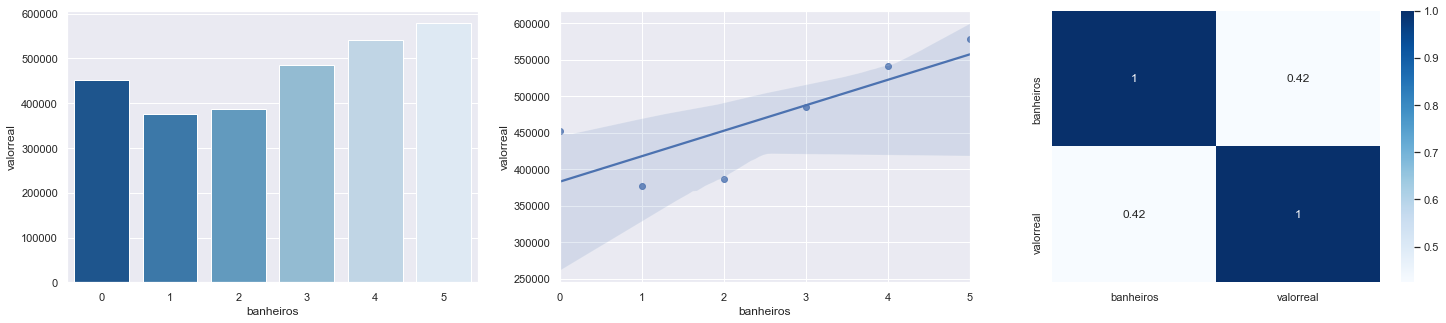

In [19]:
aux = df[['banheiros','valorreal']].groupby('banheiros').mean().reset_index()

plt.figure(figsize=(25,5))

#barplot
plt.subplot(1,3,1)
sns.barplot(x = 'banheiros',y = 'valorreal', data = aux, palette='Blues_r')

#regplot
plt.subplot(1,3,2)
sns.regplot(x = 'banheiros',y = 'valorreal', data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df[['banheiros', 'valorreal']].corr(method = 'pearson'), annot = True, cmap='Blues')

* Pelo gráfico de barras notamos que existe uma tedência de quanto mais banheiros maior é seu valor.
* Analisando o gráfico de dispersão e a matriz de correlação vemos uma correlação positiva entre quantidade de banheiros e o valor do mesmo, e essa correlação é forte.
* A hipótese é verdadeira.

### **H3** Imóveis com mais quartos devem ser mais caros.

<AxesSubplot:>

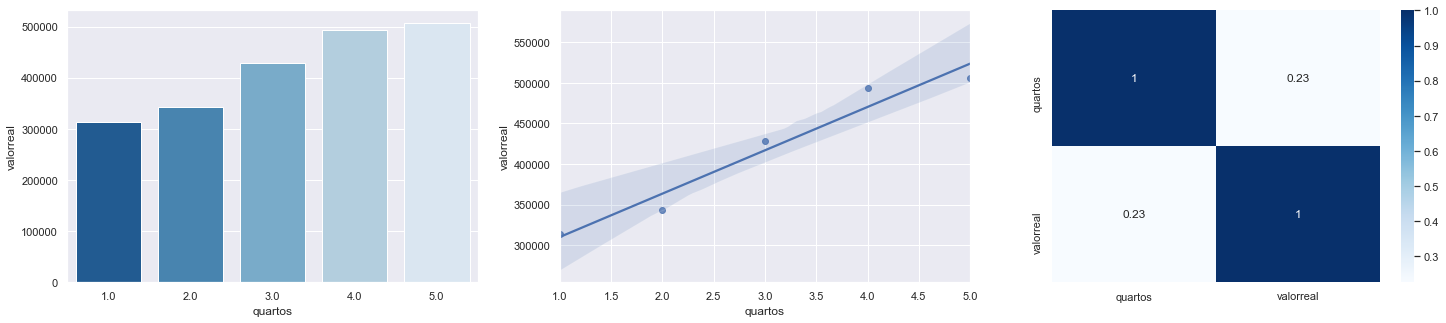

In [20]:
aux = df[['quartos','valorreal']].groupby('quartos').mean().reset_index()

plt.figure(figsize=(25,5))

#barplot
plt.subplot(1,3,1)
sns.barplot(x = 'quartos',y = 'valorreal', data = aux, palette='Blues_r')

#regplot
plt.subplot(1,3,2)
sns.regplot(x = 'quartos',y = 'valorreal', data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df[['quartos', 'valorreal']].corr(method = 'pearson'), annot = True, cmap='Blues')

* Pelo gráfico de barras notamos que existe uma tedência de quanto mais quartos maior é seu valor.
* Analisando o gráfico de dispersão e a matriz de correlação vemos uma correlação positiva entre quantidade de quartos e o valor do mesmo, porém essa correlação é fraca.
* A hipótese é verdadeira.

### **H4** Imóveis com maior área devem ser mais caros.

<AxesSubplot:>

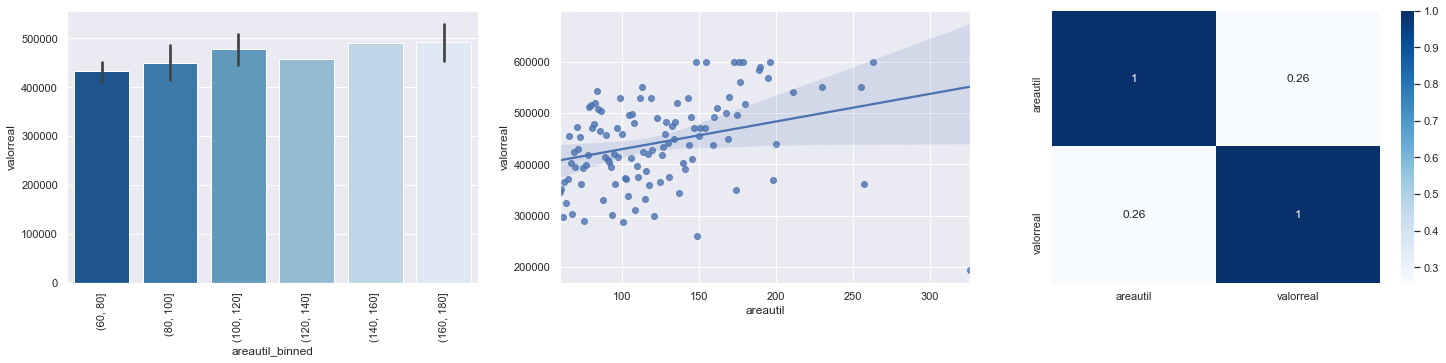

In [21]:
plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
aux = df[['areautil','valorreal']].groupby('areautil').mean().reset_index()
bins = list(np.arange(60,200,20))
aux['areautil_binned'] = pd.cut(df['areautil'], bins = bins )
sns.barplot(x = 'areautil_binned',y = 'valorreal', data = aux, palette='Blues_r')
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'areautil', y = 'valorreal', data = aux)

plt.subplot(1,3,3)
sns.heatmap(df[['areautil','valorreal']].corr(method = 'pearson'), annot = True, cmap='Blues')

* Pelo gráfico de barras notamos que existe uma tedência inicial de quanto maior o imóvel maior é seu valor, porém a partir dos imóveis de 120m2 houve uma queda nos valores.
* Analisando o gráfico de dispersão e a matriz de correlação vemos uma correlação positiva entre tamanho do imóvel e o valor do mesmo, porém essa correlação é fraca.
* A hipótese é verdadeira, com exceção de alguns imóveis que se econtram numa faixa de tamanho entre 120 e 140m2.

### **H5** Imóveis localizados em regiões mais populosas devem ser mais caros.

População dos bairros de Recife-PE - fonte: http://basilio.fundaj.gov.br/pesquisaescolar./index.php?option=com_content&view=article&id=500&Itemid=1).

In [22]:
#Carregando dados de população dos bairros de Recife-PE
df2 = pd.read_excel('../data/populacaobairros.xlsx')
#Filtrando bairros contidos no dataframe de imóveis
bairros = df.bairro.unique()
#Dataframe de população dos bairros que aparecem no dataframe de imóveis.
df2_filtrado = df2.loc[df2['BAIRRO'].isin(bairros)]

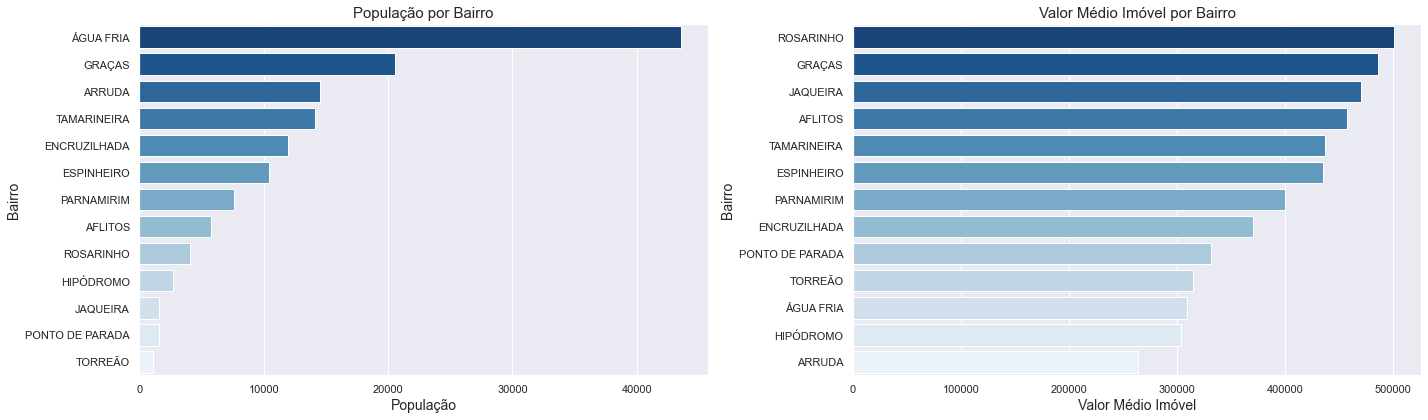

In [23]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.barplot(x='POPULACAO', y="BAIRRO", data=df2_filtrado, order=df2_filtrado.sort_values('POPULACAO', ascending = False).BAIRRO, palette='Blues_r')
plt.xlabel("População", size=14)
plt.ylabel("Bairro", size=14)
plt.title("População por Bairro", size=15)
plt.tight_layout()
plt.savefig("populacao_por_bairro.png", dpi=100)

plt.subplot(1,2,2)
aux = df[['bairro','valorreal']].groupby('bairro').mean().reset_index()
sns.barplot(x = 'valorreal',y = 'bairro', data = aux, order = aux.sort_values('valorreal', ascending = False).bairro, palette='Blues_r')
plt.xlabel("Valor Médio Imóvel", size=14)
plt.ylabel("Bairro", size=14)
plt.title("Valor Médio Imóvel por Bairro", size=15)
plt.tight_layout()
plt.savefig("valor_medio_imovel_por_bairro.png", dpi=100)

Pela ordem de bairros mais populosos e ordem dos bairros com valor médio do imóvel mais alto, podemos concluir que não existe a hipótese de imóveis em regiões mais populosas serem mais caros, ou seja, a hipótese é falsa.

### **H6** Imóveis localizados mais próximos ao centro devem ser mais caros.

Latitude e Logintude dos bairros retiradas do google maps.

In [59]:
#Carregando dados de população dos bairros de Recife-PE
df3 = pd.read_excel('../data/geolocalizacaobairros.xlsx')

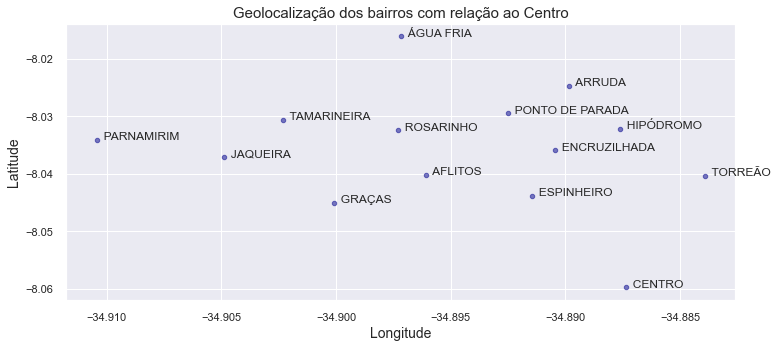

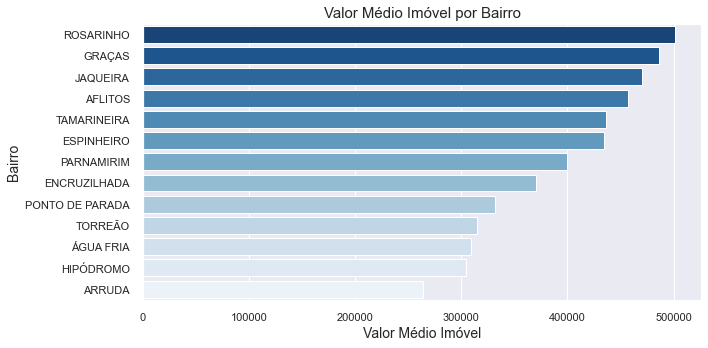

In [67]:
df3.plot.scatter(x='LONGITUDE', y='LATITUDE', alpha=0.5, color='DarkBlue', figsize=(11,5));

#Nome dos bairros nos pontos.
for i in range(df3.shape[0]):
    plt.annotate("  " + df3.BAIRRO.tolist()[i], (df3.LONGITUDE.tolist()[i], df3.LATITUDE.tolist()[i]))

plt.xlabel("Longitude", size=14)
plt.ylabel("Latitude", size=14)
plt.title("Geolocalização dos bairros com relação ao Centro", size=15)
plt.tight_layout()
plt.savefig("geolocalizacao_bairros_centro.png", dpi=100)

plt.figure(figsize=(10,5))
aux = df[['bairro','valorreal']].groupby('bairro').mean().reset_index()
sns.barplot(x = 'valorreal',y = 'bairro', data = aux, order = aux.sort_values('valorreal', ascending = False).bairro, palette='Blues_r')
plt.xlabel("Valor Médio Imóvel", size=14)
plt.ylabel("Bairro", size=14)
plt.title("Valor Médio Imóvel por Bairro", size=15)
plt.tight_layout()
plt.savefig("populacao_por_bairro_v2.png", dpi=100)

Pela distribuição da geolocalização (lat,long) dos bairros e o valor médio dos imóveis, podemos concluir que a hipótese é falsa visto que por exemplos os 3 primeiros bairros com valor médio maior não são os 3 bairros mais próximos do centro.

## Análise Multivariada

### Visualização preliminar dos Dados Númericos

Algumas visualizações de dados preliminares para ter uma ideia melhor de como o conjunto de dados se parece.

Visualizações:

* Histograma (distribuição)
* Mapa de Calor de Correlação
* Dispersão e Linha de Regressão

#### Histograma (distribuição)

#### Mapa de Calor de Correlação

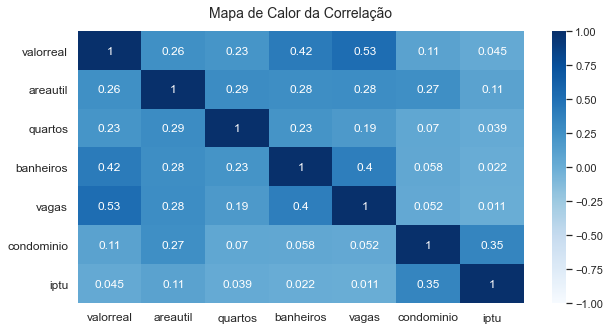

In [26]:
# Plotagem de mapa de calor com as correlações entre os atributos.
plt.figure(figsize=(10, 5))
correlation = df.corr(method='pearson')
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='Blues',annot_kws={"size": 12})
plt.style.use('seaborn')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
heatmap.set_title('Mapa de Calor da Correlação', fontdict={'fontsize':14}, pad=14);

In [27]:
# Verificando os atributos com a correlação mais alta para a mais baixa com o valorreal.
correlation['valorreal'].sort_values(ascending=False)

valorreal     1.000000
vagas         0.530380
banheiros     0.424743
areautil      0.257865
quartos       0.225868
condominio    0.105606
iptu          0.045470
Name: valorreal, dtype: float64

#### Dispersão e Linha de Regressão

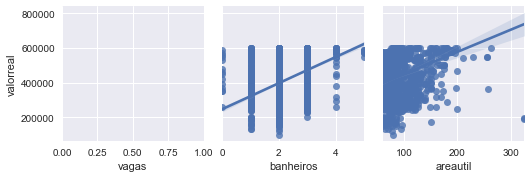

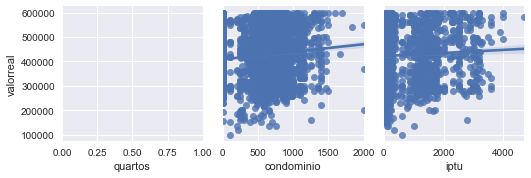

In [28]:
# Matriz de gráfico de dispersão com linha de regressão das maiores correlações com o valorreal.
sns.pairplot(df, x_vars=["vagas", "banheiros", "areautil"], y_vars="valorreal", kind='reg');
sns.pairplot(df, x_vars=["quartos","condominio","iptu"], y_vars="valorreal", kind='reg');

### Achados dados Numéricos:

* Ao contrário do que pensamos, a quantidade de **Vagas de Garagem** e a **Quantidade de Banheiros** tem mais correlação com o **Valor do Imóvel** do que o **Tamanho do Imóvel**.

### Visualização preliminar dos Dados Categóricos

Algumas visualizações de dados preliminares para ter uma ideia melhor de como o conjunto de dados se parece.

Visualizações:

* Visualização 1
* Visualização 1
* Visualização 1